# Исследование рынка видеоигр

### Цель и задачи исследования
Цель - планирование кампании на 2017 год
Задачи:
- Выявление самых прибыльных платформ
- Оценка влияния критиков на продажи
- Выявление наиболее прибыльных жанров
- составление портрета пользователя по регионам(платформы, жанры, возрастной рейтинг)
- Проверка гипотезы о том что пользовательский рейтинг Xbox One и PC одинаковый
- Проверка гипотезы о том что пользовательские рейтинги игр жанра action и sport разные

### Общая информация о датасете

In [1]:
# !pip install --upgrade pandas -q
# !pip install --upgrade matplotlib -q

In [2]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
try:
    df = pd.read_csv('games.csv')
except FileNotFoundError:
    df = pd.read_csv('####')

In [5]:
display(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Всего в датасете 16715 строк. Продажи по регионам заполнены полностью. В первых 8‑ми столбцах пропущенных значений почти нет, зато в последних трёх, где содержатся рейтинги пользователей, критиков и возрастной рейтинг не хватает до 50% процентов записей. Данные представлены с 1980 по 2016 год. Половина выборки укладывается в 28 лет с [1980 по 2007], вторая в 9 с [2008 по 2016]. Рекорд по прадажам установила северная америка с 41.36 миллионами проданных копий одного тайтла.

### Подготовка данных

In [6]:
# Приведём столбцы к нижнему регистру
df.columns = df.columns.str.lower()

In [7]:
# посмотрим на датафрейм и оценим какие типы столбцов можно заменить
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
# Кандидаты на замену типа столбцы year of release и user_score
df.loc[df.user_score == 'tbd', 'user_score'] = -9
df['user_score'] = df.user_score.astype('float64')
df.loc[df.year_of_release.isna(), 'year_of_release'] = -9
df['year_of_release'] = df.year_of_release.astype(int)

В таблице был изменён тип столбца user_score с object на float, так как рейтинг это численное значение. Для этого пришлось заменить строковую запись 'tbd', по всей видимости расшифровывающейся to be determined, на -9. Такое значение выбрано специально, поскольку оно явно выпадает из рейтинга и его будет легко найти в последующем. Также был изменён тип столбца year_of_release с float на int, для красоты графиков в будущем, иначе .0 будет мозолить глаза. Для этого пришлось заполнить отсутствующие значения цифрой -9.

In [9]:
# Итого мы заменили
print('Заменили в user_score', sum(df.user_score == -9), 'значений, tbd -> -9')
print('Заменили в year_of_release', sum(df.year_of_release == -9), 'значений, NaN -> -9')

Заменили в user_score 2424 значений, tbd -> -9
Заменили в year_of_release 269 значений, NaN -> -9


In [10]:
# Посчитаем процент пропущенных значений в нашей таблице
pd.DataFrame(round(df.isna().mean()*100,))

,0
name,0.0
platform,0.0
year_of_release,0.0
genre,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0
other_sales,0.0
critic_score,51.0
user_score,40.0


Видно, что в столбцах critic_score, user_score и rating очень много пропущенных значений. Заполнять я их не буду, поскольку считаю средняя или медиана может быть не репрезентативна, когда столько значений пропущено.

Игры "без рейтинга" shape (6621, 11)


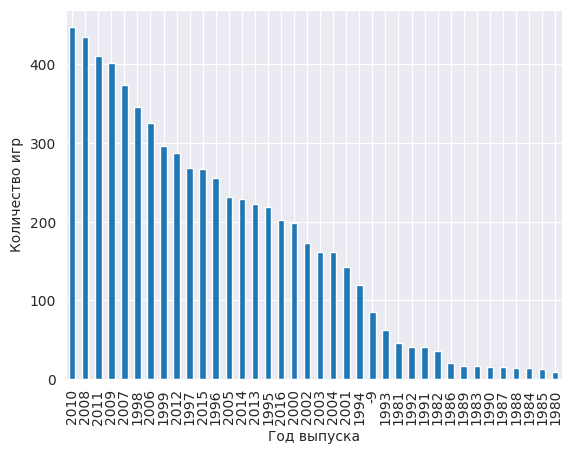

In [11]:
# Взглянем на игры без рейтингов
no_rating_games = df[(df.critic_score.isna()) & (df.user_score.isna()) & (df.rating.isna())]
no_rating_games.year_of_release.value_counts().plot(kind='bar', xlabel='Год выпуска', ylabel='Количество игр');
print('Игры "без рейтинга" shape', no_rating_games.shape)

Похоже, что в большинстве случаев отсутствуют одновременно 3 столбца: critic_score, user_score и rating, всего таких значений 6621. Моим изначальным предположением было что рейтинги отсутствуют в основном у старых и очень старых игр, но глядя на столбиковую диаграмму такой вывод сделать нельзя. Так как в 2015 таких игр более 250.

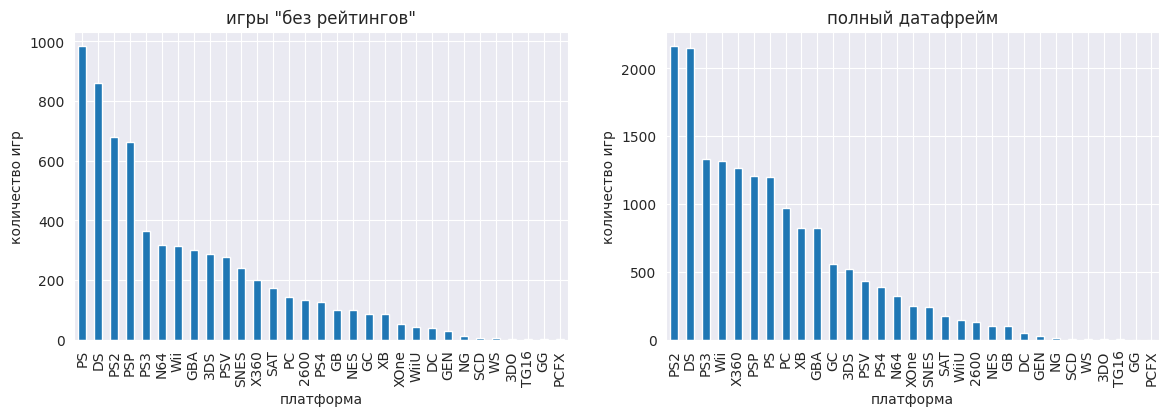

In [12]:
# Сравним платформы для игр с пропусками в рейтингах и без
figure, axis = plt.subplots(1, 2, figsize=(14, 4))
no_rating_games.platform.value_counts().plot(kind='bar', xlabel='платформа', ylabel='количество игр', title='игры "без рейтингов"', ax=axis[0])
df.platform.value_counts().plot(kind='bar', xlabel='платформа', ylabel='количество игр', title="полный датафрейм", ax=axis[1]);

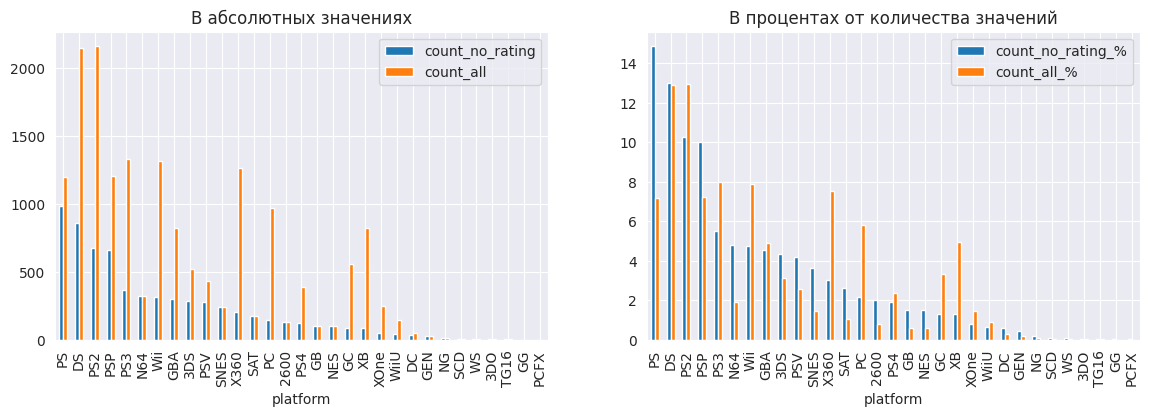

In [13]:
figure, axis = plt.subplots(1,2, figsize=(14, 4))

platform_count = pd.concat([no_rating_games.platform.value_counts(), df.platform.value_counts()], axis=1)
platform_count.columns = ['count_no_rating', 'count_all']
platform_count.reset_index(inplace=True)
platform_count.plot(x='platform', y=['count_no_rating', 'count_all'], kind='bar', ax = axis[0], title='В абсолютных значениях')
platform_count['count_no_rating_%'] = platform_count['count_no_rating']/no_rating_games.shape[0]*100
platform_count['count_all_%'] = platform_count['count_all']/df.shape[0]*100
platform_count.plot(x='platform', y=['count_no_rating_%', 'count_all_%'], kind='bar', ax = axis[1], title='В процентах от количества значений');

И все-таки, возможно, гипотеза о том что рейтинги не проставляются на старые игры может быть верна. Мы видим что в группе "без рейтинга" лидирует оригинальный плейстейшн, старая PSP в процентном отношении обгоняет PSP в общем датасете. Возможно одни и те же игры считаются разными играми в зависимости от платформы? И когда выходит новая игра на нескольких платформах, старые платформы просто игнорируются оценщиками. Для этого надо проверить датафрейм на полные и частичные дубли.

In [14]:
print("Полные дубли, shape", df[df.duplicated()].shape)
duplicated_games = df[df.name.duplicated(keep=False)].sort_values(by='name')
print("Дубли по имени, shape", duplicated_games.shape)
display(pd.DataFrame(round(duplicated_games.isna().mean()*100,)).style.background_gradient('coolwarm'))
duplicated_games.head()

Полные дубли, shape (0, 11)
Дубли по имени, shape (7961, 11)


,0
name,0.000000
platform,0.000000
year_of_release,0.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,36.000000
user_score,23.000000


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.00,0.05,NaN,NaN,NaN
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,-9.0,T
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T


Итак, 47 процентов нашего датасета являются дублями одних и тех же игр на разных платформах. Часть из них тоже "без рейтингов", но доля в этой подгруппе меньше чем в общей выборке, поэтому гипотезу о том что пропуски появляются из-за старых платформ мы тоже не можем подтвердить. Возможно две гипотезы о старых играх и старых платформах влияют одновременно, или в базу данных не внесли данные. Или просто игра была настолько не популярной, что никто не удосужился её оценить. Также возможен вариант, что игра выходила только, например, в Японии, а головной офис, где формируется база данных, находится в Америке.

In [15]:
# Поиск частичных дублей
display(implicit_dup := df[df[['name', 'platform','year_of_release']].duplicated(keep=False)])
df = df.drop(implicit_dup.index[1:])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Проверка на неявные дубликаты выявила 2 задублированные игры. В случае MaddenNFL первую запись можно оставить, так как она несёт в себе полезную информацию в отличие от второй, где отсутствуют продажи и рейтинги. Во втором случае неизвестно название игры, поэтому отбрасываем обе записи.

In [16]:
# Создадим столбец с суммарными продажами
df['sales_sum'] = df.eu_sales + df.na_sales + df.jp_sales + df.other_sales
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_sum
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


В этом разделе была проведена подготовка данных. В первую очередь были поменяны типы столбцов user_score с object на float и year_of_release с float на int. Также было обнаружено большое количество(до 50%) пропущенных значений в 3х столбцах с рейтингами. После чего были проверены 2 предположения. Первое о том что рейтинги отсутствуют у старых игр и второй о том что рейтинги отсутствуют у одних и тех же игр на разных платформах, другими словами если выставили рейтинг на одной то вторую оценивать не стали. Оба предположения не подтвердились. Затем данные очищены от явных и неявных дубликатов. В процессе было обнаружено большое количество(47%) дублей по имени, одних и тех же игр для разных платформ.

### Исследовательский анализ данных

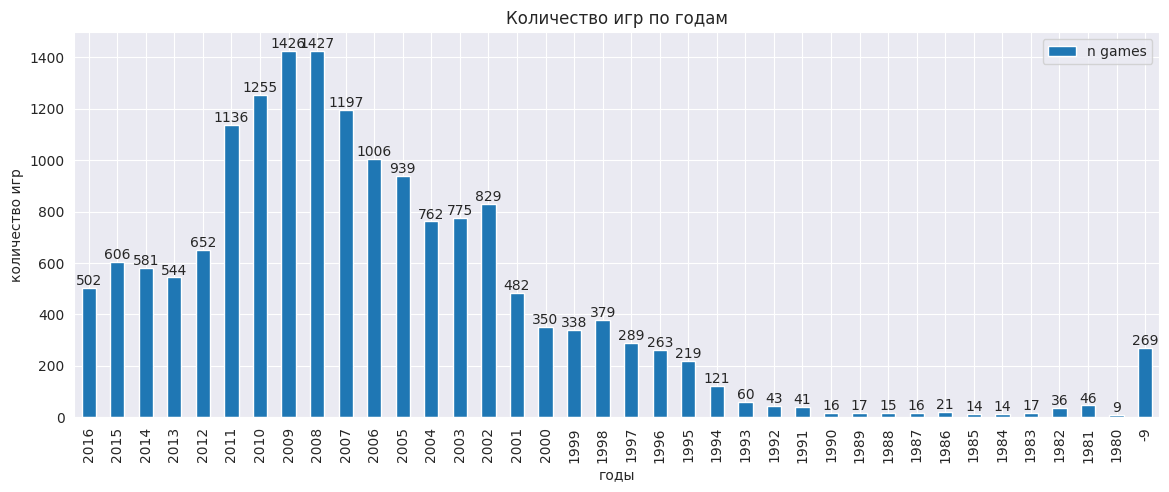

In [17]:
# Рассмотрим количество игр по годам
n_games_by_year_pivot = df.pivot_table(index='year_of_release', values='name', aggfunc='count')\
    .sort_values(by='name', ascending=False).sort_index(ascending=False)
n_games_by_year_pivot.rename({'name': 'n games'}, axis=1, inplace=True)
ax = n_games_by_year_pivot.plot(kind='bar', title='Количество игр по годам',
                                ylabel='количество игр', xlabel='годы', figsize=(14, 5))
ax.bar_label(ax.containers[0]);
# Исходя из полученных данных предлагаю отсечь игры, которые были выпущены ранее 1995 года, так как их очень мало
df = df.query('year_of_release == -9 or year_of_release >= 1995')

Количество игр выпущенных в 94 году в 2 раза меньше количества игр выпущенных в 95. В качестве отсечки выбран 95 год, всё что ниже отбрасываем, кроме -9, это те игры у которых не проставлен год выпуска.

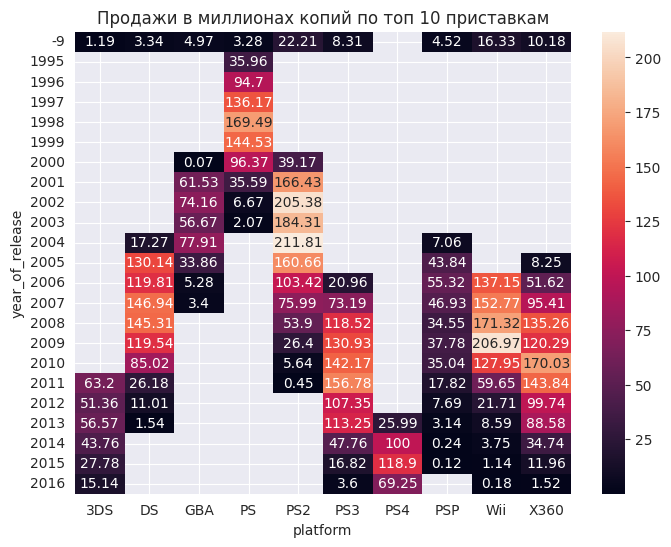

In [18]:
# Рассчитаем суммарные продажи по платформам, а затем построим распределение по годам.
sales_sum_by_platform_pivot = df.pivot_table(index='platform', values='sales_sum', aggfunc='sum').sort_values(by='sales_sum', ascending=False)
top_10 = sales_sum_by_platform_pivot.iloc[0:10, :]
sales_pivot = df.query('platform.isin(@top_10.index)')\
                       .pivot_table(
                        index='year_of_release',
                        columns='platform',
                        values='sales_sum',
                        aggfunc='sum'
                       )
plt.figure(figsize=(8, 6))
sns.heatmap(sales_pivot, fmt='g', annot=True).set(title='Продажи в миллионах копий по топ 10 приставкам');

Из графика видно, что средний срок жизни платформы составляет около 10 лет, наибольшие продажи приходятся на первую половину жизненного цикла. За период с 1995 по 2016 год новая платформа появлялась каждые 5 лет.

In [19]:
# Срежем данные за актуальный период
df_actual = df.query('year_of_release >= 2013')
print('Размерность таблицы с актуальным срезом', df_actual.shape)

Размерность таблицы с актуальным срезом (2233, 12)


Судя по тепловой карте выше, индустрия живет циклами по 5-6 лет. Жизненный срок игровой консоли 2 цикла, потом её обновляют. Возьмём срез с 2013 года, за последние 4 года. 2013 выбран поскольку в этот год были выпущены сразу 2 мэйнстримных консоли PS4 и Xbox One.

In [20]:
# Вытащим приставки, которые присутствуют на рынке в 2016
platform_year_sales_sum = df_actual.groupby(['platform', 'year_of_release']).agg({'sales_sum': 'sum'})
display(platform_year_sales_sum.head())
platforms_2016 = list(map(lambda x: x[0], filter(lambda x: True if x[1] == 2016 else False, platform_year_sales_sum.index)))
df_actual = df_actual.query('platform.isin(@platforms_2016)')
# Посчитаем насколько меньше или больше было продано копий в 2016 в сравнении с предыдущим годом.
display(platform_year_sales_sum.groupby(level = 'platform').agg({'sales_sum': lambda x: x.diff().iloc[-1]}))
# Посчитаем кто больше всего продал
df_actual.pivot_table(index='platform', values='sales_sum', aggfunc='sum')

sales_sum
platform year_of_release           
3DS      2013                 56.57
         2014                 43.76
         2015                 27.78
         2016                 15.14
DS       2013                  1.54

,sales_sum
platform,
3DS,-12.64
DS,NaN
PC,-3.27
PS3,-13.22
PS4,-49.65
PSP,-0.12
PSV,-2.00
Wii,-0.96
WiiU,-11.75


,sales_sum
platform,
3DS,143.25
PC,39.43
PS3,181.43
PS4,314.14
PSV,32.99
Wii,13.66
WiiU,64.63
X360,136.80
XOne,159.32


Из выборки удалены все приставки которые не актуальны(нет поддержки производителя, не выпускаются игры) на 2016 год. У всех оставшихся платформ в сравнении с предыдущим годом продажи падают, минимальное падение у Nintendo Wii - 960 000 копий. Максимальное падение у PS4 - 49 650 000 копий. По всей видимости на рынке что-то происходит, либо у нас не полные данные.

средняя от медиан по продажам 0.193


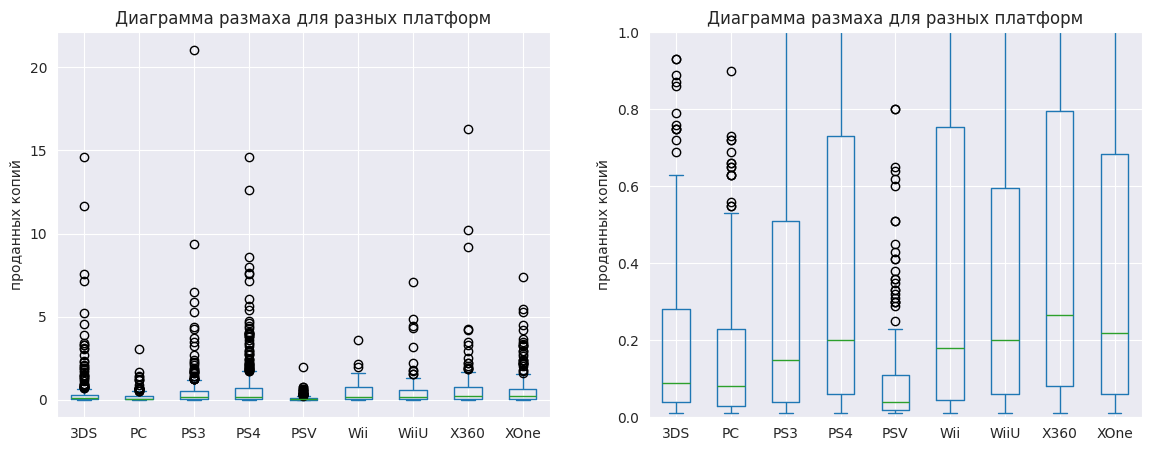

In [21]:
figure, axis = plt.subplots(1,2, figsize=(14, 5))
box = []
labels = []
for platform, vals in df_actual.groupby('platform'):
    box.append(vals.sales_sum.reset_index(drop=True).rename(platform))
    labels.append(platform)
box = pd.concat(box, axis=1)
box.plot(kind='box', ylabel='проданных копий', title='Диаграмма размаха для разных платформ', ax=axis[0])
box.plot(kind='box', ylabel='проданных копий', title='Диаграмма размаха для разных платформ', ax=axis[1], ylim=(0, 1));
print(f'средняя от медиан по продажам {df.groupby("platform").sales_sum.median().mean():.3f}')

На графике для всех платформ очень много выбросов, с очень большими продажами в несколько миллионов, это популярные игры типа Halo или Call of Duty, при этом половина игр на всех платформах продается в количестве менее 193 000 копий.

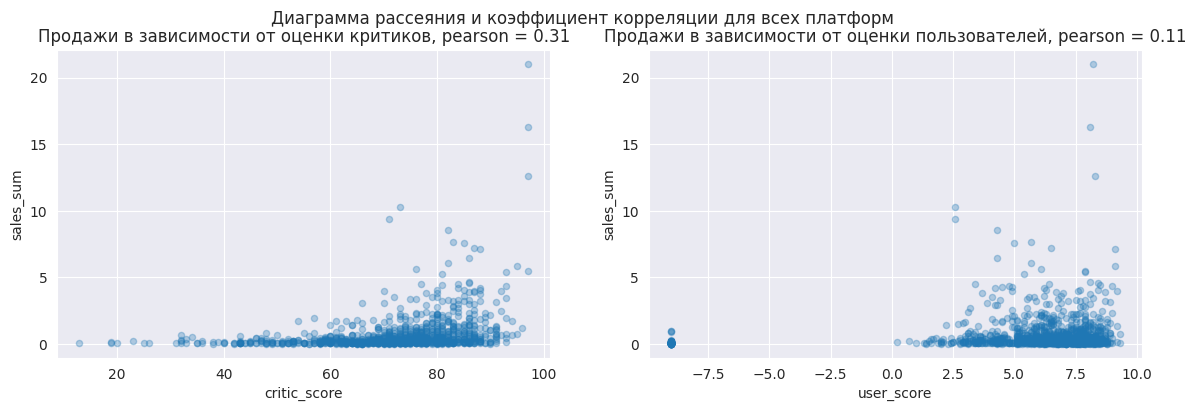

In [22]:
# Проверим как отзывы и обзоры влияют на продажи
def reviews_sales_corr(df, platform):
    figure, axis = plt.subplots(1, 2, figsize=(14, 4))
    def get_not_na_val(df, review_type):
        return df[~df[review_type].isna()].index
    not_na_critics = get_not_na_val(df, 'critic_score')
    try:
        corr_critics = st.pearsonr(df['critic_score'].loc[not_na_critics], df['sales_sum'].loc[not_na_critics])
        df.plot(x='critic_score', y='sales_sum', ax = axis[0], alpha=0.3,
                kind='scatter', 
                title=f'Продажи в зависимости от оценки критиков, pearson = {corr_critics.statistic:.2f}')
    except ValueError:
        axis[0].text(
            x = -0.04,
            y = 0,
            s = f"""Недостаточно значений для рассчёта корреляции, 
                          всего {len(df['critic_score'].loc[not_na_critics])} значений""",
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
        ),
        df.plot(x='critic_score', y='sales_sum', legend=False, 
                title=f'Продажи в зависимости от оценки критиков',
                kind='scatter',
                ax = axis[0], 
                alpha=0.3)
    not_na_users = get_not_na_val(df, 'user_score')
    try:
        corr_users = st.pearsonr(df['user_score'].loc[not_na_users], df['sales_sum'].loc[not_na_users])
        df.plot(x='user_score', y='sales_sum', ax = axis[1], alpha=0.3,
                kind='scatter', title=f'Продажи в зависимости от оценки пользователей, pearson = {corr_users.statistic:.2f}')
    except ValueError:
            axis[1].text(
            x = -0.04,
            y = 0,
            s = f"""Недостаточно значений для рассчёта корреляции, 
                          всего {len(df['critic_score'].loc[not_na_critics])} значений""",
            bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10}
            ),
            df.plot(x='users_score', y='sales_sum', legend=False, 
                    title=f'Продажи в зависимости от оценки пользователей',
                    kind='scatter',
                    ax = axis[0], 
                    alpha=0.3)

        
    plt.suptitle(f'Диаграмма рассеяния и коэффициент корреляции для {platform}')

reviews_sales_corr(df_actual, 'всех платформ')

На графиках видно, что между отзывами и продажами есть слабая положительная связь. Причем критики в 2 раза сильнее влияют на продажи в сравнении с пользователями. Также на графике для пользователей видны выбросы, это игры в пользовательском рейтинге которых были записи вида 'tbd', я заменил их на -9, что-бы привести тип данных столбца к float. Посмотрим что будет если удалить эти значения.

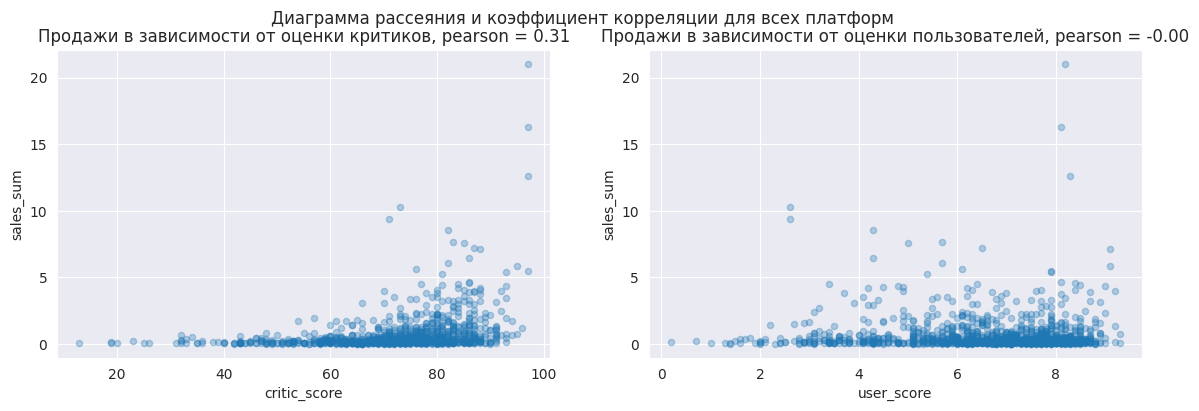

In [23]:
reviews_sales_corr(df_actual.query('user_score != -9 and critic_score != -9'), 'всех платформ')

После удаления записей где user_score = -9 коэффициент корреляции для пользователей упал до 0. Для критиков же он составляет слабые 0.31. Посмотрим что будет по каждой платформе в отдельности.

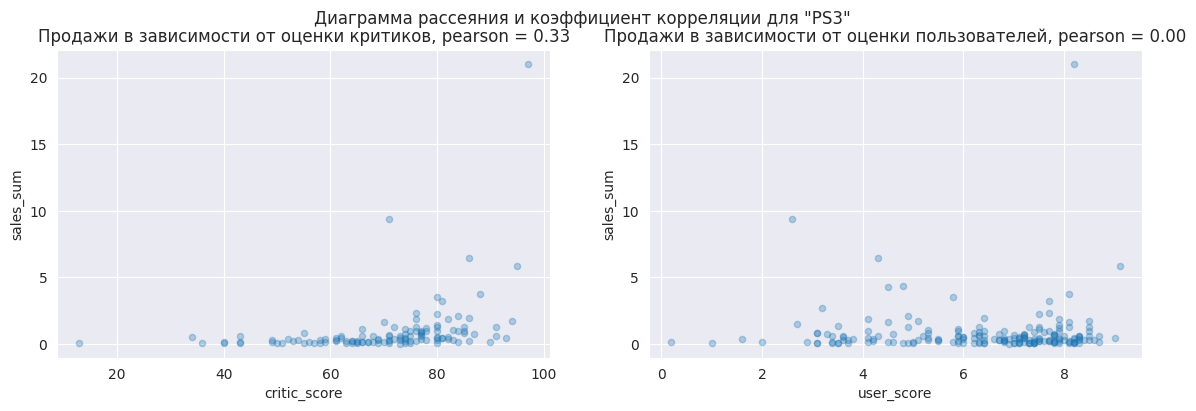

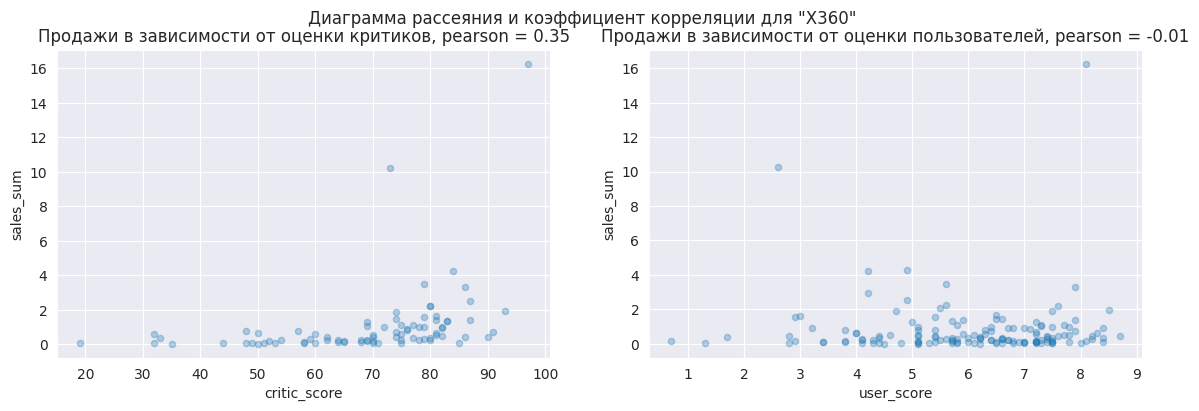

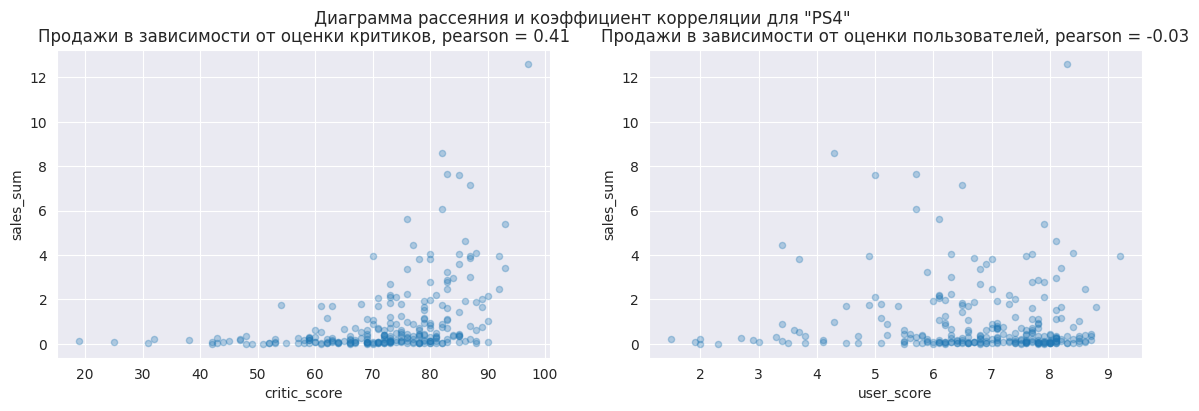

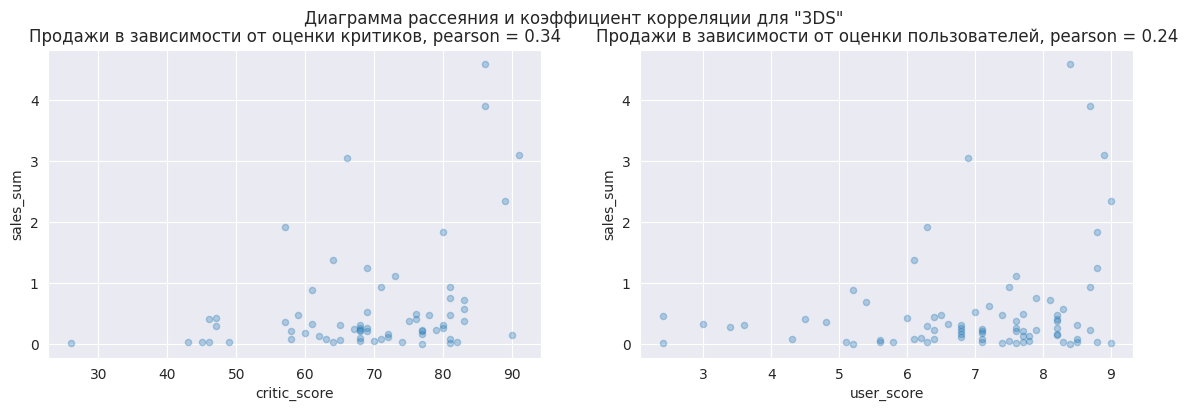

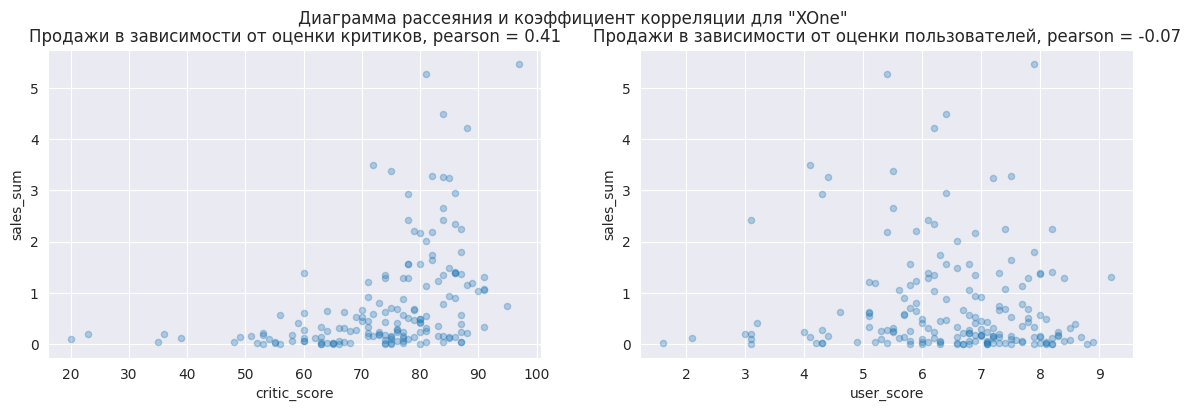

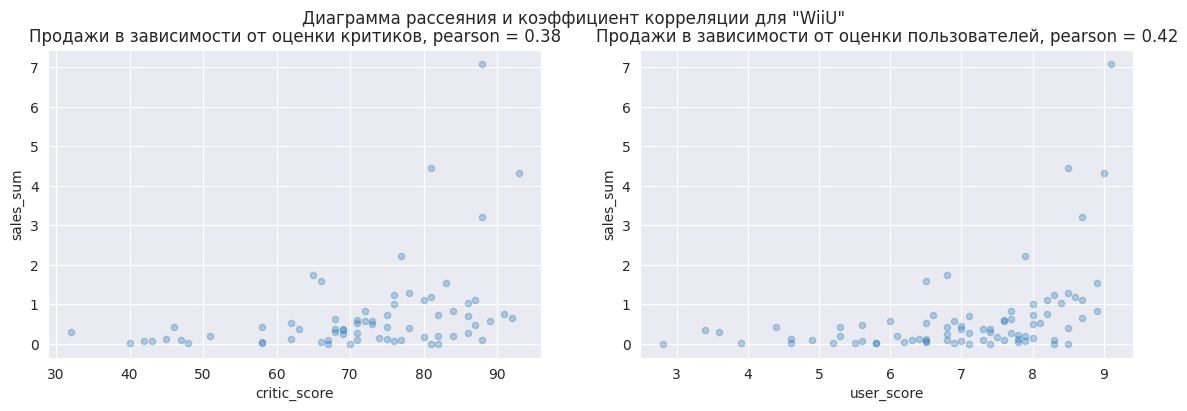

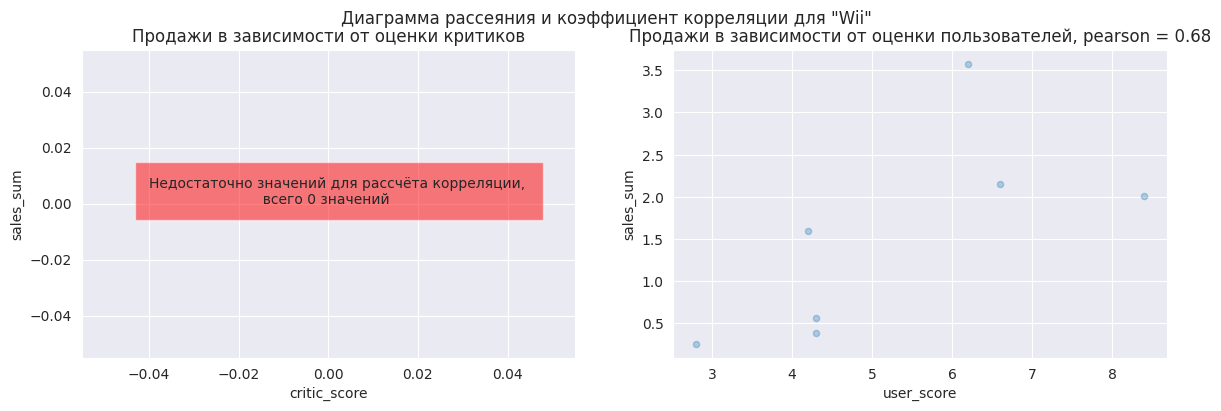

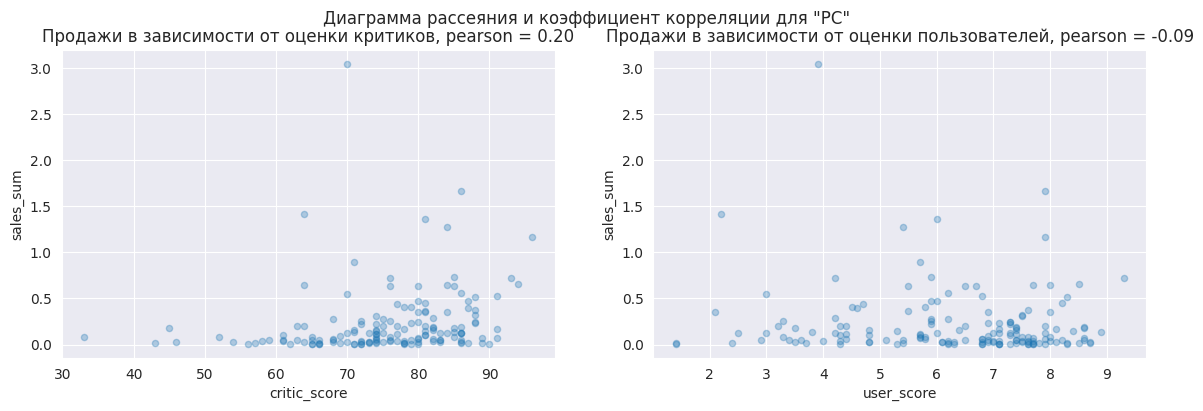

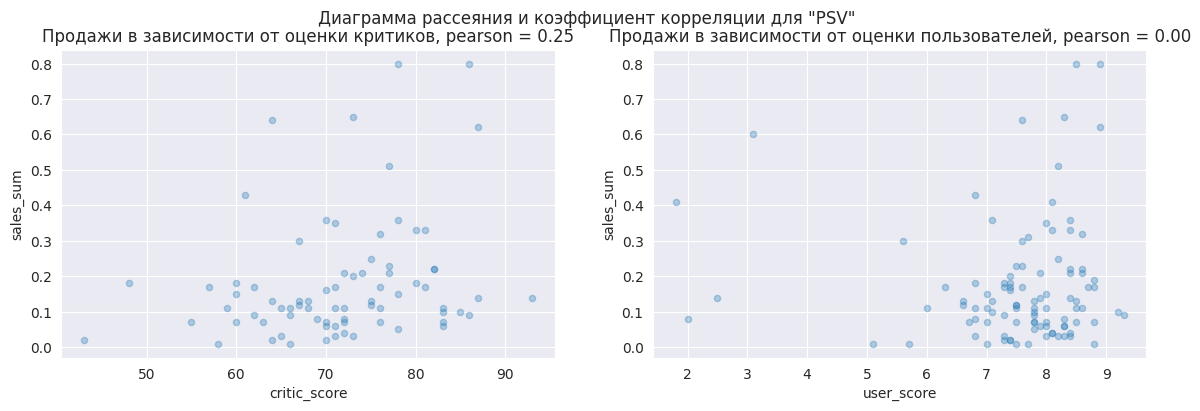

In [24]:
for platform in df_actual.platform.unique():
    reviews_sales_corr(df_actual.query(f'platform == "{platform}" and user_score != -9'), f'"{platform}"')

In [25]:
# Количество игр для Wii
df_actual.query('platform == "Wii"').shape

(23, 12)

Корреляция между отзывами критиков и продажами слабая положительная, а иногда очень слабая положительная. Максимальное значение у Xbox One и PS4. Корреляция между пользовательскими отзывами и продажами в основном около нуля, за исключением приставок от nintendo: WiiU - 0.42 и 3DS - 0.24. Причем для WiiU пользовательская корреляция даже выше чем корреляция критиков. В целом можно сделать вывод, что отзывы слабо влияют на продаваемость игр. Также надо отметить среднюю корреляцию между пользовательскими отзывами и продажами для платформы Wii, но она скорее всего объясняется очень малым количеством игр для которых есть рейтинги и в целом малым количеством игр для Wii выпущенных за период, всего 23 штуки.

,count,median,sum
genre,,,
Action,3284,0.180000,1672.720000
Sports,2279,0.220000,1279.920000
Misc,1730,0.160000,785.890000
Role-Playing,1451,0.180000,891.950000
Adventure,1290,0.050000,214.510000
Shooter,1274,0.220000,979.030000
Racing,1226,0.180000,697.590000
Simulation,858,0.150000,381.130000
Platform,818,0.230000,614.050000


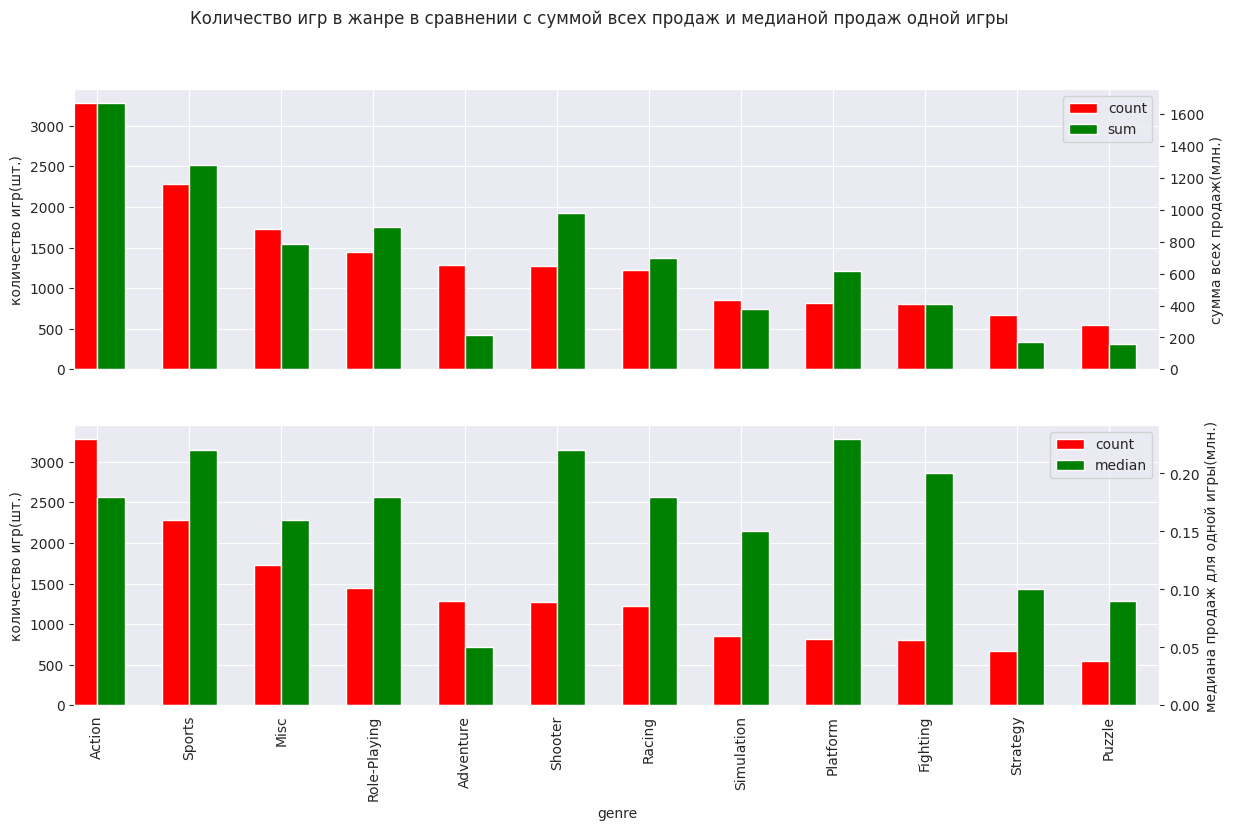

In [26]:
# Рассмотрим на распределение и прибыль игр по жанрам
figure, axis = plt.subplots(2,1, figsize=(14, 8))
genre_counts = pd.DataFrame(df.genre.value_counts())#.plot(kind='bar', ax=axis[0])
genre_sales_sum_median = df.pivot_table(index='genre', values='sales_sum', aggfunc={'sales_sum': ['sum', 'median']})
genre_pivot = genre_counts.join(genre_sales_sum_median)
genre_pivot.plot(kind='bar', y='count', ax=axis[0], color='red', ylabel='количество игр(шт.)', position=1, width=0.3, sharex=True)
genre_pivot.plot(kind='bar', y='sum', ax=axis[0], secondary_y=True, ylabel='сумма всех продаж(млн.)', color='green',
                 mark_right=False, position=0, width=0.3, align='center', sharex=True)
genre_pivot.plot(kind='bar', y='count', ax=axis[1], color='red', ylabel='количество игр(шт.)', position=1, width=0.3, sharex=True)
genre_pivot.plot(kind='bar', y='median', ax=axis[1], secondary_y=True, ylabel='медиана продаж для одной игры(млн.)', color='green',
                 mark_right=False, position=0, width=0.3, align='center', sharex=True);
plt.suptitle('Количество игр в жанре в сравнении с суммой всех продаж и медианой продаж одной игры');
#Взглянем на точные цифры
genre_pivot.style.background_gradient('coolwarm')

Жанры игр отсортированы слева на право в порядке убывания количества игр в них. Больше всего игр в жанре Action, меньше всего в жанре Puzzle. В целом по первому графику можно сказать что в большинстве случаев количество продаж примерно соответствует количеству выпущенных игр. Самой прибыльной представляется категория shooter, а убыточными категории adventure, strategy и puzzle. Однако проанализировав второй график можно сказать что в целом в жанрах strategy и puzzle не всё так плохо, так как у них неплохие медианные продажи. Что касается adventure, то он плохо показал себя и на втором графике. Также второй график подтверждает что шутеры неплохо продаются. Также среди лидеров оказались игры жанра platform. Что касается игр класса action, он является самым популярным и в нем больше всего игр, однако медиана продаж для одной игры у него не самая большая.

### Портрет пользователя каждого региона

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,38.200000,30.960000,67.810000,6.280000
PS3,63.500000,67.810000,23.350000,26.770000
PS4,108.740000,141.090000,15.960000,48.350000
PSV,5.040000,6.100000,18.590000,3.260000
XOne,93.120000,51.590000,0.340000,14.270000


na_sales       308.60
eu_sales       297.55
jp_sales       126.05
other_sales     98.93
dtype: float64

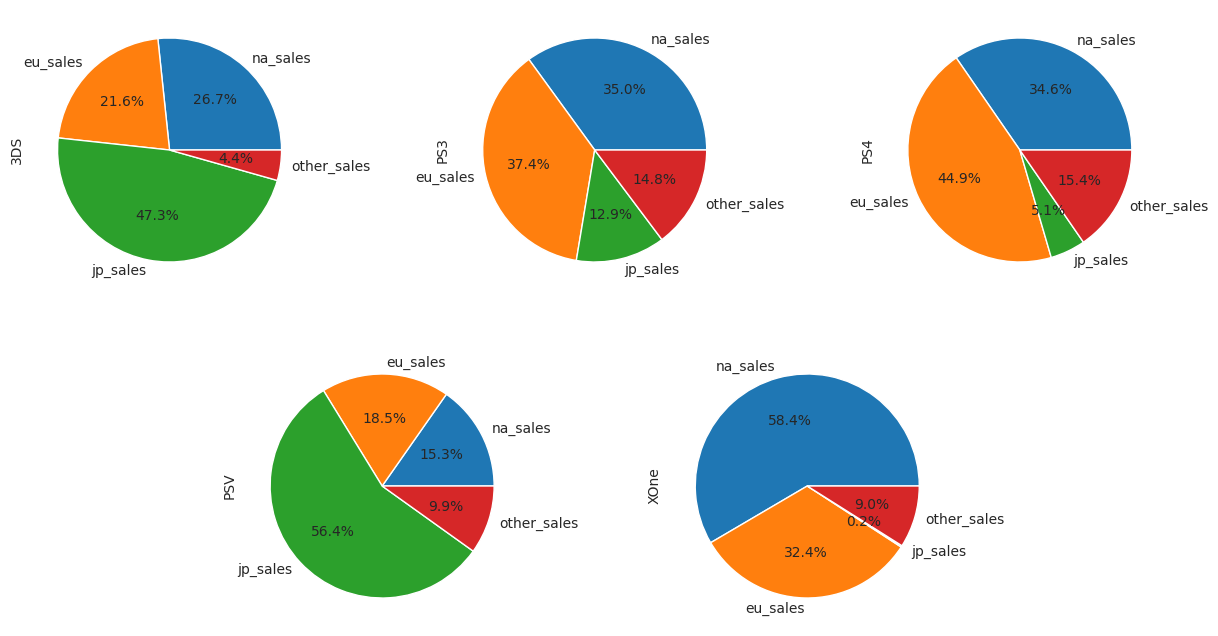

In [27]:
# Определим популярность приставок по регионам
top5 = tuple(df_actual.platform.value_counts().index[0:5])
platform_sales_by_region = df_actual.query('platform.isin(@top5)').groupby('platform').apply(lambda x: [x['na_sales'].sum(),
                                                                                                        x['eu_sales'].sum(),
                                                                                                        x['jp_sales'].sum(),
                                                                                                        x['other_sales'].sum()])
platform_sales_by_region = pd.DataFrame(data=platform_sales_by_region.to_list(),
                                        columns=('na_sales', 'eu_sales', 'jp_sales', 'other_sales'),
                                        index=platform_sales_by_region.index)
plt.figure(figsize=(16, 8))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
platform_sales_by_region.loc['3DS', :].plot(kind='pie', autopct='%1.1f%%', ax=ax1)
platform_sales_by_region.loc['PS3', :].plot(kind='pie', autopct='%1.1f%%', ax=ax2)
platform_sales_by_region.loc['PS4', :].plot(kind='pie', autopct='%1.1f%%', ax=ax3)
platform_sales_by_region.loc['PSV', :].plot(kind='pie', autopct='%1.1f%%', ax=ax4)
platform_sales_by_region.loc['XOne', :].plot(kind='pie', autopct='%1.1f%%', ax=ax5);
display(platform_sales_by_region.style.background_gradient('coolwarm'))
platform_sales_by_region.apply(lambda x: sum(x))

3DS лидирует на родном для себя рынке в японии, на которую приходится 47.3% мировых продаж игр, на втором месте северная америка с 26.7%. PS3 примерно одинаково популярен в европе и америке с 37.4 и 35 процентами соответственно. В японии почему-то у PS3 дела идут не очень хорошо, на неё приходится всего лишь 12.9 от мировых продаж игр. PS4 наиболее популярен в европе - 44.9%, на втором месте северная америка - 34.6, на последнем Япония с 5.1% от мировых продаж. PSV наиболее популярна в Японии, 56.4%, на втором месте европа с 18.5%, на последним категория "другие страны". XOne наиболее популярен у себя на родине в северной америке, с 58.4% от мировых продаж игр. В Японии продажи игр на XOne практически отсутствуют, на неё приходится менее 1% проданных игр. Рекордсмен продаж за период PS4 c 141 миллионом проданых игр.

genre
Role-Playing    50.01
Action          39.65
Misc             9.03
Shooter          6.61
Sports           4.91
Name: jp_sales, dtype: float64

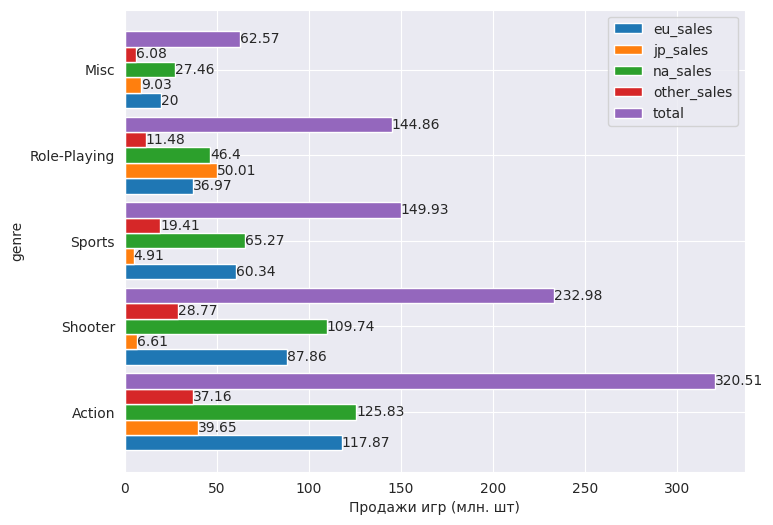

In [28]:
# теперь посмотрим какие жанры популярны по регионам.
sales_by_region = df_actual.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum', margins_name='Total')
sales_by_region['total'] = sales_by_region.apply(lambda x: x.sum(), axis=1)
sales_by_region = sales_by_region.sort_values(by='total', ascending=False).iloc[0:5]
ax = sales_by_region.plot.barh(xlabel='Продажи игр (млн. шт)', width=0.9, figsize=(8, 6))
for container in ax.containers:
    ax.bar_label(container)
sales_by_region['jp_sales'].sort_values(ascending=False)

Наиболее популярные жанры это, в порядке убывания популярности: action, shooter, sports, role-playing и misc. Жанр action на первом месте потому что это термин зонтик, который может скрывать под собой несколько жанров. Например, shooter и role-playing(не всегда) также относятся к классу action. Второе место занимает жанр shooter, его популярность скорее всего обусловлена тем что шутеры очень часто это высоко бюджетные игры с большим рекламным бюджетом, а также имеют большой потенциал сетевой игры. Механика игр класса shooter основана на реакции и ловкости управления персонажем, что позволяет отвлечься от быта и втягивает в игру. На третьем месте жанр sports, тут очевидно всё держится на фанатах спортивных команд футбола, баскетбола, хоккея и американского футбола. Role-playing игры на четвертом месте, они популярны из-за того что такие игры делают упор на сюжет и развитие персонажа. Игры типа misc на пятом месте потому что в эту категорию скорее всего попали все казуальные игры рассчитанные на широкую аудиторию, в топ 5 эта категория попала поскольку людей не особо интересующихся видеоиграми гораздо больше, чем игроков. Такой порядок получился для всех кроме Японии. В Японии на первом месте Role-Playing игры, игры класса action на втором, Misc на третьем, Shooter на четвертом, а Sports на последнем, пятом. Возможно это связано с особенностями культуры.

,eu_sales,jp_sales,na_sales,other_sales,games N
rating,,,,,
E,82.800000,15.000000,78.940000,22.530000,296
E10+,42.530000,5.890000,54.020000,12.540000,250
M,145.320000,14.110000,165.210000,47.040000,369
T,41.950000,20.440000,49.790000,14.290000,332
no rating,78.610000,82.050000,89.180000,23.410000,911


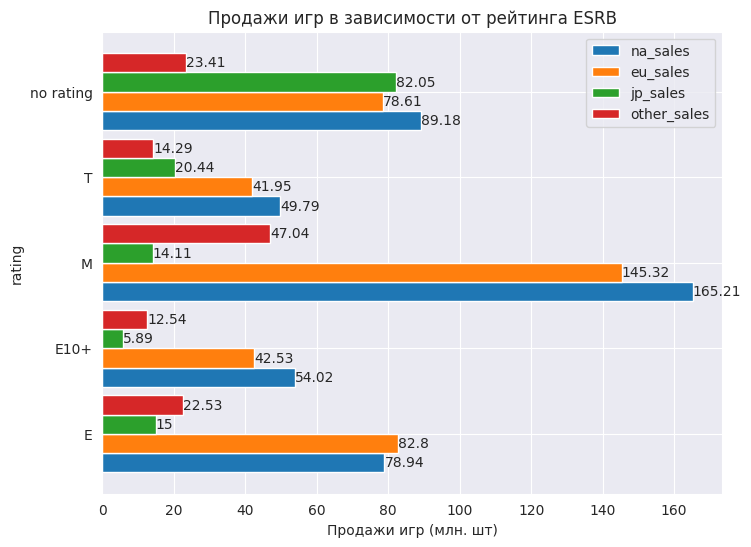

In [29]:
# Выясним влияет ли рейтинг ESRB на продажи по регионам.
df_actual['rating'] = df_actual['rating'].fillna('no rating')
rating_pivot = df_actual.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], aggfunc='sum')
sales_by_rating = df_actual.pivot_table(index='rating', values='name', aggfunc='count')
sales_by_rating = sales_by_rating.rename({'name':'games N'}, axis=1)
rating_pivot = rating_pivot.join(sales_by_rating)
rating_pivot = rating_pivot.query('rating != "RP"')
ax = rating_pivot.plot.barh(xlabel='Продажи игр (млн. шт)',
                            y=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                            title='Продажи игр в зависимости от рейтинга ESRB',
                            width=0.9, figsize=(8, 6))
for container in ax.containers:
    ax.bar_label(container)

display(rating_pivot.style.background_gradient('coolwarm'))

Расшифровка рейтинга ESRB:
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет

По общему количеству игр лидируют игры без рейтинга - 911 тайтлов, с двукратным отставанием следуют игры категории M - 369 тайтлов. Странно что продажи игр без рейтинга почти одинаковые между северной америкой, европой и Японией, ведь Японский рынок гораздо меньше, для М и Е10+ северная америка на порядок опережает Японию. С учетом того что игры без рейтинга самая большая категория продаются они не очень хорошо, продажи составляют половину от продаж категории М, при том что количество игр в М в 2 раза меньше. Из графика видно, что лучше всего продаются игры категории M, но не в Японии, где категория M находится на третьем месте, а на первом месте игры без рейтинга которые кратно, а в некоторых случаях и на порядок обгоняют другие категории. Так как ESRB североамериканская организация, то она оценивает только игры которые выпускаются в Америке и Канаде(в соответствии с википедией), а значит туда не попадают игры выпущенные только на локальном Японском рынке. Что говорит о большой специфичности рынка.

### Проверка гипотез

In [30]:
# Проверим гипотезу о равенстве средних пользовательских рейтингов Xbox One и PC
pc = df_actual[df_actual[['platform', 'user_score']].platform == 'PC'].user_score.dropna()
xbox_one = df_actual[df_actual[['platform', 'user_score']].platform == 'XOne'].user_score.dropna()
pval = st.ttest_ind(xbox_one, pc).pvalue
if pval > 0.05:
    print(f'pvalue = {pval:.2}, не можем отвергнуть нулевую гипотезу')
else:
    print(f'Нулевая гипотеза отвергнута, pval = {pval}')
print(f"среднее xboxone: {xbox_one.mean():.2}, среднее PC: {pc.mean():.2}")

pvalue = 0.68, не можем отвергнуть нулевую гипотезу
среднее xboxone: 5.6, среднее PC: 5.8


$H_0$: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

$H_1$: Средние пользовательские рейтинги платформ Xbox One и PC не равны

$\alpha$ = 0.05

Нулевая гипотеза всегда говорит о равенстве средних в выборках. Альтернативная предполагает различие между выборками, односторонний либо двусторонний тест. Несмотря на то, что надо показать равенство средних, нулевой гипотезой берем именно равенство. Для проверки был применён двусторонний тест, так как не важно в большую или меньшую сторону отличаются выборки, главное показать что они отличаются. Пороговое значение $\alpha$ выбрано конвенционально. Использована версия теста для двух независимых выборок, поскольку между выборками нет зависимости и они легко помещаются в память компьютера.

Т-тест показал значение pvalue = 0.68, это говорит о том что такое различие между средними можно получить случайно в 68 случаях из 100. 0.68 сильно больше $\alpha$=0.05, поэтому мы не можем отвергнуть $H_0$.

In [31]:
# Проверим, отличаются ли пользовательские рейтинги жанров action и sports
action = df_actual.query('genre == "Action"').user_score
sports = df_actual.query('genre == "Sports"').user_score
pval = st.ttest_ind(action, sports, nan_policy='omit').pvalue
if pval > 0.05:
    print(f'pvalue = {pval:.2}, не можем отвергнуть нулевую гипотезу')
else:
    print(f'Нулевая гипотеза отвергнута, pval = {pval:.2}')
print(f"среднее action: {action.mean():.2}, среднее sports: {sports.mean():.2}")

Нулевая гипотеза отвергнута, pval = 0.013
среднее action: 5.3, среднее sports: 4.2


$H_0$: Средние пользовательские рейтинги игр в жанре Action и Sports одинаковые

$H_1$: Средние пользовательские рейтинги игр в жанре Action и Sports отличаются

$\alpha$ = 0.05

Нулевая гипотеза всегда говорит о равенстве средних в выборках. Альтернативная предполагает различие между выборками, односторонний либо двусторонний тест. В данном случае нам необходимо проверить альтернативную гипотезу. Для проверки был применён двусторонний тест, так как не важно в большую или меньшую сторону отличаются выборки, главное показать что они отличаются. Пороговое значение $\alpha$ выбрано конвенционально. Использована версия теста для двух независимых выборок, поскольку между выборками нет зависимости и они легко помещаются в память компьютера.

Т-тест показал значение pvalue = 0.013, это говорит о том что такое различие между средними маловероятно(нужно около 100 повторений эксперимента что-бы получить такую разницу случайно), 0.013 меньше $\alpha$=0.05, поэтому отвергаем $H_0$ в пользу $H_1$.


### Вывод

В данной работе был проанализирован датасет содержащий информацию о продажах видеоигр и сопутствующей информации(платформы, рейтинги, годы выпуска) по регионам.

В первую очередь была оценена общая информация. Всего в датасете 16715 строк. В рейтинги пользователей, критиков и в возрастном рейтинге не хватает до 50% процентов записей. Данные представлены с 1980 по 2016 год.

На этапе подготовки данных были поменяны типы столбцов year_of_release и user_score. В первом случае float был поменян на int, а во втором с object на float. Было принято решение не заполнять пропуски в данных так как в столбцах, где это необходимо, а именно 3 столбца с рейтингами пропущено слишком много значений(до 50%) для того что-бы экстраполировать среднее или медианное значение на весь столбец. Также на этом этапе анализа было обнаружено, что 47 процентов нашего датасета являются дублями одних и тех же игр на разных платформах.

Результаты исследовательского анализа данных показали что средний срок жизни игровой платформы составляет около 10 лет, наибольшие продажи приходятся на первую половину жизненного цикла. За период с 1995 по 2016 год новая платформа появлялась каждые 5 лет. Судя по тепловой карте выше, индустрия живет циклами по 5-6 лет. Исходя из этого был подготовлен актуальный срез данных с 2013 года. 2013 год выбран поскольку в этот год были выпущены сразу 2 мэйнстримных консоли PS4 и Xbox One, таким образом мы захватим все актуальные платформы на момент 2017. Затем из данных были удалены платформы поддержка которых на 2016 была прекращена. Также была посчитана динамика продаж по сравнению с предыдущим годом. У всех платформ в сравнении с предыдущим годом продажи падают, минимальное падение у Nintendo Wii - 960 000 копий. Максимальное падение у PS4 - 49 650 000 копий. Данные продаж разбитые по платформам характеризуются большим количеством мощных выбросов, продажи которых могут быть на несколько порядков больше медианы. Между отзывами критиков и продажами обнаружена слабая положительная связь, а между отзывами пользователей и продажами связи не обнаружено. В большинстве случаев количество продаж примерно соответствует количеству выпущенных игр. Самой прибыльной представляется категория shooter, а самая убыточная категория - adventure. Класс action является самым популярным и в нем больше всего игр, однако медиана продаж для одной игры у него не самая большая.

Затем был составлен портрет пользователя каждого региона. По платформам: 3DS лидирует на родном для себя рынке в японии, на которую приходится 47.3% мировых продаж игр, на втором месте северная америка с 26.7%. PS3 примерно одинаково популярен в европе и америке с 37.4 и 35 процентами соответственно. В японии почему-то у PS3 дела идут не очень хорошо, на неё приходится всего лишь 12.9 от мировых продаж игр. PS4 наиболее популярен в европе - 44.9%, на втором месте северная америка - 34.6, на последнем Япония с 5.1% от мировых продаж. PSV наиболее популярна в Японии, 56.4%, на втором месте европа с 18.5%, на последним категория "другие страны". XOne наиболее популярен у себя на родине в северной америке, с 58.4% от мировых продаж игр. В Японии продажи игр на XOne практически отсутствуют, на неё приходится менее 1% проданных игр. Рекордсмен продаж за период PS4 c 141 миллионом проданых игр. По жанрам: наиболее популярные жанры это, в порядке убывания популярности: action, shooter, sports, role-playing и misc. Жанр action на первом месте потому что это термин зонтик, который может скрывать под собой несколько жанров. Такой порядок получился для всех кроме Японии. В японии на первом месте Role-Playing игры, игры класса action на втором, Misc на третьем, Shooter на четвертом, а Sports на последнем, пятом. По рейтингам от ESRB: по общему количеству игр лидируют игры без рейтинга - 911 тайтлов, с двукратным отставанием следуют игры категории M - 369 тайтлов. Странно что продажи игр без рейтинга почти одинаковые между северной америкой, европой и Японией, ведь Японский рынок гораздо меньше, для М и Е10+ северная америка на порядок опережает Японию. С учетом того что игры без рейтинга самая большая категория продаются они не очень хорошо, продажи составляют половину от продаж категории М, при том что количество игр в М в 2 раза меньше. Лучше всего в мире продаются игры категории M, но не в Японии, где категория M находится на третьем месте, а на первом месте игры без рейтинга которые кратно, а в некоторых случаях и на порядок обгоняют другие категории. Так как ESRB североамериканская организация, то она оценивает только игры которые выпускаются в Америке и Канаде(в соответствии с википедией), а значит туда не попадают игры выпущенные на локальном Японском рынке. Что говорит о большой специфичности рынка.

Далее было проверено 2 гипотезы. Первая гипотеза о равенстве средних пользовательских рейтингов Xbox One и PC где т-тест показал значение pvalue = 0.68, что говорит о том что такое различие между средними можно получить случайно в 68 случае из 100. 0.68 сильно больше $\alpha$=0.05, поэтому мы не можем отвергнуть $H_0$(рейтинги равны). И вторая гипотеза об отличиях пользовательских рейтингов жанров action и sports. Где т-тест показал значение pvalue = 0.013, это говорит о том что такое различие между средними маловероятно, необходимо около 100 повторений эксперимента что-бы получить такую разницу. 0.013 меньше $\alpha$=0.05, поэтому отвергаем $H_0$(рейтинги равны) в пользу $H_1$(рейтинги отличаются).

__Общий вывод__: Примерно в половине случаев игры выпускаются сразу для нескольких платформ, похоже издатели таким образом снижают свои риски расширяя потенциальную аудиторию. Приставки обновляются примерно 1 раз в 10 лет новые мэйнстримные консоли появились в 2013. Продажи Xbox One достаточно слабые, он не попадает в топ 5, в отличие от PS4. Японский рынок большой, но очень специфичный, распределение по жанрам и по платформам у него другое. Его размер в 3 раза меньше северо американского и европейского рынков, в то же время он сопоставим с категорией "другие страны". Странно что серия PS не пользуется популярностью у себя дома. Есть подозрение, что в Японии популярны игры которые продаются только в Японии и разрабатываются там же. __Бизнесу__: Что касается прогнозов на 2017 год то наиболее перспективным представляется американский рынок, затем европейский. Ориентироваться надо в первую очередь на них, вместе они составляют более 70% общемирового рынка. Более того, они похожи по своей структуре, там популярны одни и те же игры, но есть некоторые различия по платформам. Похожая структура по жанрам у категории "другие страны", по платформам эта категория ближе к европейской. По сравнению с 2015 продажи на всех платформах упали, возможна рецессия. Под Японский рынок надо подстраиваться и скорее всего придется взаимодействовать с местными издателями.